### HW_6

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

##### Ответ

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):

    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:

            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:

            target = gb_predict(X_train, trees, coefs, eta)
            
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees[-1], train_errors[-1], test_errors[-1]

In [8]:
eta = 0.1

n_trees_array = [i for i in range(1, 100, 10)]

train_n_trees_error_array = []
test_n_trees_error_array = []

for n_trees in n_trees_array:
        
    coefs = [1] * n_trees
    max_depth = 5

    tr, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_n_trees_error_array.append(train_error)
    test_n_trees_error_array.append(test_error)

In [9]:
def get_n_trees_error_plot(n_trees_array, train_err, test_err):
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees_array[-1])
    plt.plot(n_trees_array, train_err, label='train error')
    plt.plot(n_trees_array, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

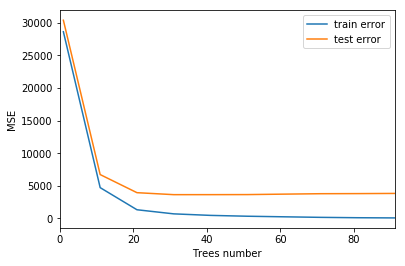

In [10]:
get_n_trees_error_plot(n_trees_array, train_n_trees_error_array, test_n_trees_error_array)

In [11]:
train_max_depth_error_array = []
test_max_depth_error_array = []

max_depth_array = [i for i in range(1, 20, 2)]

for max_depth in max_depth_array:

    n_trees = 50
    coefs = [1] * n_trees

    tr, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_max_depth_error_array.append(train_error)
    test_max_depth_error_array.append(test_error)

In [12]:
def get_depth_error_plot(max_depth_array, train_err, test_err):
    plt.xlabel('Max depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth_array[-1])
    plt.plot(max_depth_array, train_err, label='train error')
    plt.plot(max_depth_array, test_err, label='test error')
    plt.legend(loc='upper left')
    plt.show()

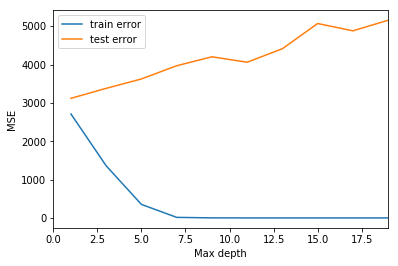

In [13]:
get_depth_error_plot(max_depth_array, train_max_depth_error_array, test_max_depth_error_array)

ВЫВОД:   
    MSE модели градиентного бустинга зависит от количества деревьев обратно пропорционально, но для максимальной глубины дерева ситуация обратная - на test выборке MSE при увеличении max_depth растёт, что говорит о переобучении модели при росте max_depth. 

----------------------------------------------------------------------------------------------------------------

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [25]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        #Формирование подвыборки    
        ind = [i for i in range(len(X_train))]
        np.random.shuffle(ind) 
        index_sample = ind[0:len(ind)//2] # размер подвыборки = 0.5
        
        X_train_2 = np.zeros((len(index_sample), X_train.shape[1]))
        y_train_2 = np.zeros((len(index_sample)))
        
        k = 0
        for i in index_sample:
            X_train_2[k, :] = X_train[i, :]
            y_train_2[k] = y_train[i]
            k += 1

        if len(trees) == 0:

            tree.fit(X_train_2, y_train_2)
            
            train_errors.append(mean_squared_error(y_train_2, gb_predict(X_train_2, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:

            target = gb_predict(X_train_2, trees, coefs, eta)
            
            tree.fit(X_train_2, bias(y_train_2, target))
            
            train_errors.append(mean_squared_error(y_train_2, gb_predict(X_train_2, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [27]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.title(f'Stochastic Gradient Boosting on {n_trees} trees')
    plt.legend(loc='upper right')
    plt.show()

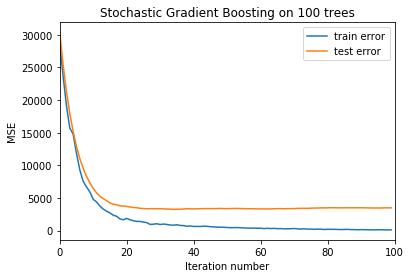

In [28]:
n_trees = 100
coefs = [1] * n_trees
max_depth = 5
eta = 0.1

trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)

ВЫВОД:
    кривая в случае стохастического градиентного бустинга получается более гладкая, чем при градиентном бустинге, и с "шероховатостями" графика на train error